# How to use the time-lagged autoencoder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
from deeptime import tae

Our test system is a simple two-dimensional two-state process with a one-dimensional dominant slow component.

We start by generating a trajectory along with the underlying hidden state time series and visualize the two-dimensional data:

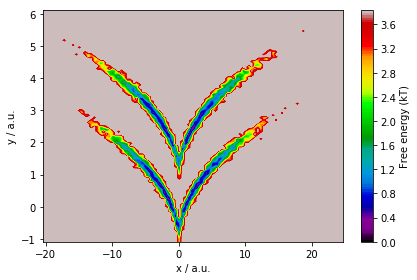

In [2]:
traj, dtraj = tae.toymodels.sample_sqrt_model(10000)

fig, ax = pyemma.plots.plot_free_energy(*traj.T, cmap=mpl.cm.nipy_spectral)
ax.set_xlabel('x / a.u.')
ax.set_ylabel('y / a.u.')
fig.tight_layout()

We clearly see two metastable shapes which are not connected along a single direction which should make it difficult to find a suitable one-dimensional representation.

In the next step, we apply the autoencoder API function to find such a one-dimensional embedding. This function returns the learned embedding and also the training and validation loss which we will visualize to show the minimization behavior:

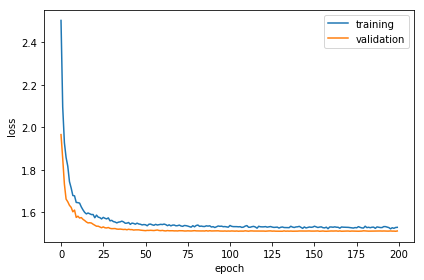

In [3]:
embedding, training_loss, validation_loss = tae.ae(
    traj, dim=1, lag=1, n_epochs=200, validation_split=0.5, whiten=True, hid_size=[200, 100])

fig, ax = plt.subplots()
ax.plot(training_loss, label='training')
ax.plot(validation_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.tight_layout()

The saturated training and validation losses hint that overfitting is unlikely.

Then, we test the one-dimensional embedding whether it has found the correct slow component by building two Markov state models (MSMs), one on the embedding and one on the hidden state trajectory, and compare their first implied timescales:

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=8), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=8), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

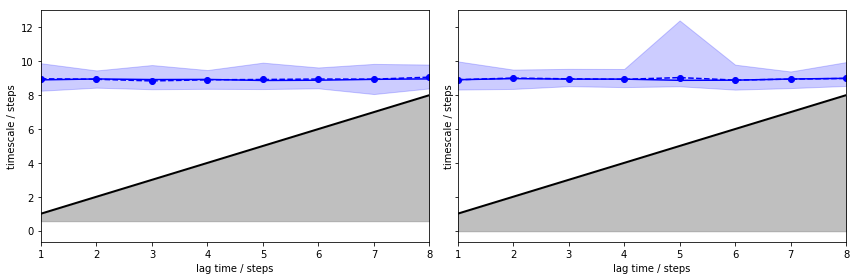

In [4]:
lags = [i + 1 for i in range(8)]

its_reference = pyemma.msm.its(dtraj, lags=lags, nits=1, errors='bayes')

embedding_centers = np.linspace(np.min(embedding), np.max(embedding), 21)
embedding_centers = 0.5 * (embedding_centers[:-1] + embedding_centers[1:]).reshape(-1, 1)
embedding_dtraj = pyemma.coordinates.assign_to_centers(embedding, centers=embedding_centers)[0]
its_embedding = pyemma.msm.its(embedding_dtraj, lags=lags, nits=1, errors='bayes')

fig, (ref, emb) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
pyemma.plots.plot_implied_timescales(its_reference, ax=ref, ylog=False)
pyemma.plots.plot_implied_timescales(its_embedding, ax=emb, ylog=False)
fig.tight_layout()

Apparently, the one-dimensional embedding contains the same kinetic information as the hidden state time series.

Finally, we test whether the MSM-based separation into metastable states reflects the original data distribution. We again plot the two-dimensional free energy surface and overlay a two-colored scatter plot indicating the metastable membership of each frame:

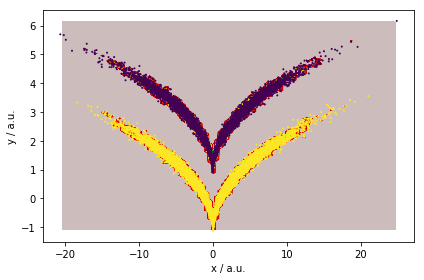

In [5]:
embedding_msm = pyemma.msm.estimate_markov_model(embedding_dtraj, lag=1)
embedding_msm.pcca(2)

embedding_mstates = -np.ones(len(embedding_centers))
for i, s in enumerate(embedding_msm.metastable_sets):
    embedding_mstates[s] = i
embedding_mtraj = embedding_mstates[embedding_dtraj]

fig, ax = pyemma.plots.plot_free_energy(*traj.T, cmap=mpl.cm.nipy_spectral, cbar=False)
ax.scatter(*traj.T, c=embedding_mtraj, s=1)
ax.set_xlabel('x / a.u.')
ax.set_ylabel('y / a.u.')
fig.tight_layout()

This separation is in perfect agreement with the two-dimensional distribution and we can conclude that the one-dimensional embedding has identified the slow component of our test system.